In [5]:
import pandas as pd
import numpy as np
import random

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df = pd.read_parquet('../data/curated/weighted_transactions.parquet')
df['merchant_abn'] = df['merchant_abn'].astype(str)
df = pd.pivot_table(
    df.groupby(
        'merchant_abn'
    ).filter(
        lambda x : x['weighted_dollar_value'].sum() > 1000
    ),
    values = 'weighted_dollar_value',
    index = ['week_idx', 'week_of_year'],
    columns = 'merchant_abn'
)

In [25]:
def fit_arima(merchant):
    week = merchant.index.get_level_values(1)
    merchant = merchant.droplevel(1)
    train = merchant[:-6]
    test = merchant[-6:]
    model = auto_arima(train, start_p=1, start_q=1, X = week,
        test='adf',
        max_p=52, max_q=52,
        m=1,             
        d=None,          
        seasonal=False,   
        start_P=0, 
        D=None, 
        trace=True,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True
    )
    prediction, confint = model.predict(n_periods=len(test), return_conf_int=True)
    prediction = pd.Series(prediction,index=test.index)
    cf= pd.DataFrame(confint)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    print(np.mean([np.abs(a - p) for a, p in zip(test, prediction)]))
    ax.plot(merchant)
    ax.plot(prediction)
    ax.fill_between(
        prediction.index,
        cf[0],
        cf[1],color='grey',alpha=.3
    )


In [26]:
fit_arima(df[df.columns[150]])

ValueError: Expected 2D array, got 1D array instead:
array=[ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43.
 44. 45. 46. 47. 48. 49. 50. 51. 52.  1.  2.  3.  4.  5.  6.  7.  8.  9.
 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [17]:
result_mul = seasonal_decompose(df.droplevel(1)[df.columns[0]],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq',
                                period = 52)

ValueError: x must have 2 complete cycles requires 104 observations. x only has 86 observation(s)

In [13]:
df

,merchant_abn,10323485998,10487253336,10618089367,10648956813,10959028715,11121775571,11199348915,11215815177,11237511112,11285988014,...,99022808555,99053443481,99229845016,99275601275,99291944648,99467302626,99803748393,99845294286,99904689266,99976658299
week_idx,week_of_year,,,,,,,,,,,,,,,,,,,,,
0,8,36.238890,12.535740,12.907969,37.205644,11.084012,21.850902,16.757125,35.625858,29.718715,13.574173,...,19.546621,7.085468,11.904545,11.494982,104.302531,31.139516,28.178090,21.773840,16.205586,84.285538
1,9,28.287173,15.066864,18.021811,33.846339,15.968902,24.182262,14.241562,25.195962,36.452820,12.480196,...,21.184981,20.692180,9.652537,10.020932,107.538575,24.115636,30.529189,27.839510,13.144919,91.490963
2,10,33.846745,8.462305,28.881562,40.038269,19.837077,25.141552,20.331014,44.659187,35.224609,22.768084,...,15.553247,24.806845,16.615994,11.118310,145.252835,28.455520,21.717691,58.593189,17.115526,86.948805
3,11,28.019978,17.217281,23.764849,35.763456,15.287169,25.133660,23.055050,21.791681,40.032217,12.090788,...,11.908842,22.097572,3.328669,10.588211,116.629953,17.689380,23.931812,45.118173,15.078206,92.192535
4,12,29.633504,23.270311,32.906544,38.554470,15.077060,27.395507,15.818006,19.720536,39.008099,13.570634,...,28.361754,44.233673,35.357390,11.920626,101.002537,18.302887,16.693151,27.384959,14.067766,82.385580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,37,49.765528,22.756363,28.203278,58.580563,25.292204,42.081581,30.201852,52.937980,45.235350,19.493552,...,22.714794,29.320823,28.530962,13.995513,175.117717,48.522023,38.131362,52.211612,26.485987,121.046772
82,38,47.911343,27.091891,45.513675,53.260724,27.387008,38.247597,33.393362,26.032652,63.083613,22.855667,...,26.959551,50.109324,25.497226,16.244770,178.807437,46.803046,35.553705,34.371518,21.111374,130.833287
83,39,60.249580,25.013303,34.194336,61.192043,29.162622,35.825030,27.111216,54.000186,51.722472,21.760245,...,28.188803,32.734952,19.375517,18.155945,164.737576,47.880955,48.643425,43.916211,28.158846,145.432557


In [12]:
prediction, confint = model.predict(n_periods=len(test), return_conf_int=True)
cf= pd.DataFrame(confint)

/root/.virtualenvs/ads_proj2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
prediction

74    6.509221
75    5.899717
76    6.444844
77    7.662274
78    6.328957
79    6.566557
80    6.847596
81    6.874610
82    6.570619
83    6.745226
84    6.780841
85    6.730252
dtype: float64

ValueError: setting an array element with a sequence.

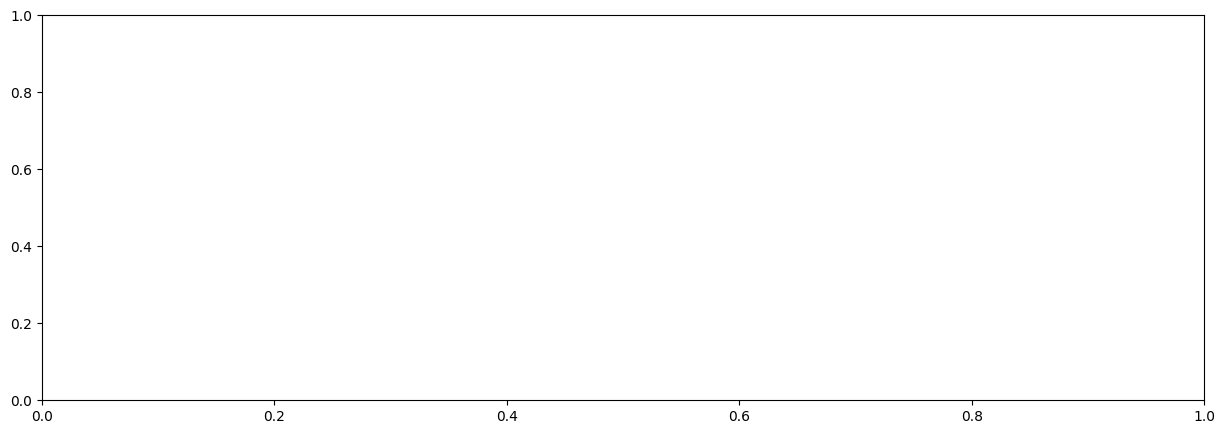

In [11]:
prediction_series = pd.Series(prediction,index=test.index.get_level_values(0))
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(merchant)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index.get_level_values(0),
                cf[0],
                cf[1],color='grey',alpha=.3)